In [2]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer

In [22]:

class PumpLeakagePredictor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        self.models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42)
        }
        self.results = {}
        
    def preprocess_data(self, data, fit=False):
        # Make a copy to avoid modifying original data
        df = data.copy()
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Extract time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        
        # Calculate pressure and temperature ranges
        df['pressure_range'] = df['pressure_1'] - df['pressure_3']
        df['temp_range'] = df['temperature_1'] - df['temperature_4']
        
        # Calculate rolling means for each sensor
        window = 5
        sensor_cols = ['pressure_1', 'pressure_2', 'pressure_3', 
                      'temperature_1', 'temperature_2', 'temperature_3', 
                      'temperature_4', 'vibration']
        
        for col in sensor_cols:
            df[f'{col}_rolling_mean'] = df[col].rolling(window=window, min_periods=1).mean()
        
        # Drop timestamp and pump_id columns
        df = df.drop(['timestamp', 'pump_id'], axis=1)
        
        # Print info about missing values
        print("\nMissing values before imputation:")
        print(df.isnull().sum())
        
        # Handle missing values
        feature_cols = [col for col in df.columns if col != 'condition']
        
        if fit:
            df_features = self.imputer.fit_transform(df[feature_cols])
            df_features = self.scaler.fit_transform(df_features)
        else:
            df_features = self.imputer.transform(df[feature_cols])
            df_features = self.scaler.transform(df_features)
        
        # Convert back to DataFrame
        df_processed = pd.DataFrame(df_features, columns=feature_cols, index=df.index)
        
        # Add back the target column if it exists
        if 'condition' in df.columns:
            df_processed['condition'] = df['condition']
        
        print("\nMissing values after imputation:")
        print(df_processed.isnull().sum())
        
        return df_processed
    
    def train(self, train_data):
        print("Processing training data...")
        df_processed = self.preprocess_data(train_data, fit=True)
        
        # Check data distribution
        print("\nData distribution:")
        print(df_processed['condition'].value_counts())
        
        # Split features and target
        X = df_processed.drop('condition', axis=1)
        y = df_processed['condition']
        
        # Split data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train and evaluate models
        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            accuracy = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='weighted')
            
            # Store results
            self.results[name] = {
                'accuracy': accuracy,
                'f1_score': f1,
                'model': model,
                'feature_names': X.columns
            }
            
            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred))
            
            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_val, y_pred)
            sns.heatmap(cm, annot=True, fmt='d')
            plt.title(f'{name} Confusion Matrix')
            plt.show()
        
        # Plot feature importance for Random Forest
        if 'Random Forest' in self.results:
            rf_model = self.models['Random Forest']
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': rf_model.feature_importances_
            })
            feature_importance = feature_importance.sort_values('importance', ascending=False)

            plt.figure(figsize=(12, 6))
            sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
            plt.title('Top 10 Most Important Features (Random Forest)')
            plt.tight_layout()
            plt.show()
    
    def predict(self, test_data):
        print("\nProcessing test data...")
        test_processed = self.preprocess_data(test_data, fit=False)
        
        # Make predictions with each model
        predictions = {}
        for name, result in self.results.items():
            predictions[f'predicted_condition_{name.replace(" ", "_")}'] = result['model'].predict(test_processed)
        
        # Add predictions to test data
        test_predictions = test_data.copy()
        for col, pred in predictions.items():
            test_predictions[col] = pred
        
        return test_predictions
    
    def print_model_comparison(self):
        comparison_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'Accuracy': [self.results[model]['accuracy'] for model in self.results],
            'F1 Score': [self.results[model]['f1_score'] for model in self.results]
        })
        print("\nModel Performance Comparison:")
        print(comparison_df)
        return comparison_df

Processing training data...

Missing values before imputation:
Unnamed: 0                    0
pressure_1                    0
pressure_2                    0
pressure_3                    0
temperature_1                 0
temperature_2                 0
temperature_3                 0
temperature_4                 0
vibration                     0
condition                     0
hour                          0
day                           0
month                         0
pressure_range                0
temp_range                    0
pressure_1_rolling_mean       0
pressure_2_rolling_mean       0
pressure_3_rolling_mean       0
temperature_1_rolling_mean    0
temperature_2_rolling_mean    0
temperature_3_rolling_mean    0
temperature_4_rolling_mean    0
vibration_rolling_mean        0
dtype: int64

Missing values after imputation:
Unnamed: 0                    0
pressure_1                    0
pressure_2                    0
pressure_3                    0
temperature_1             

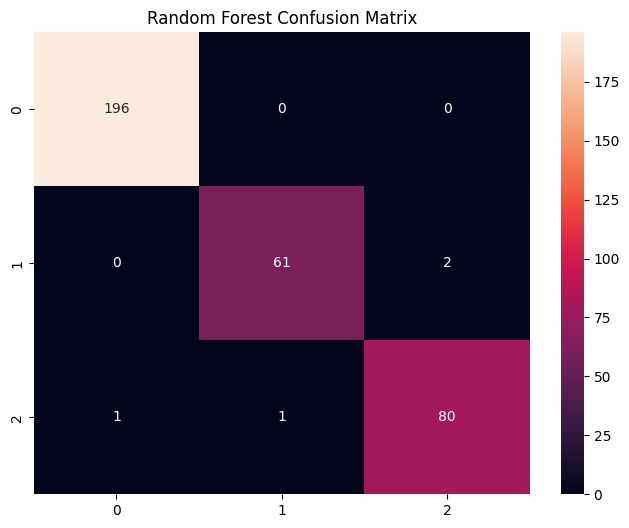


Training Gradient Boosting...
Accuracy: 0.9795
F1 Score: 0.9794

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       196
           1       0.93      0.98      0.95        63
           2       0.99      0.93      0.96        82

    accuracy                           0.98       341
   macro avg       0.97      0.97      0.97       341
weighted avg       0.98      0.98      0.98       341



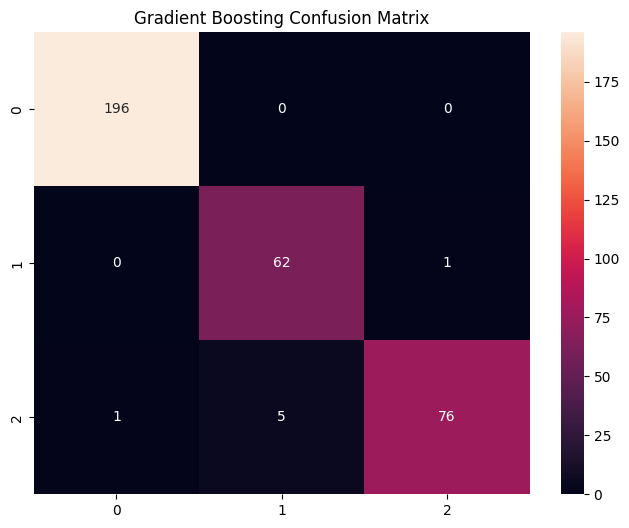


Training SVM...
Accuracy: 0.8387
F1 Score: 0.8295

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       196
           1       0.61      0.84      0.71        63
           2       0.95      0.49      0.65        82

    accuracy                           0.84       341
   macro avg       0.82      0.77      0.77       341
weighted avg       0.86      0.84      0.83       341



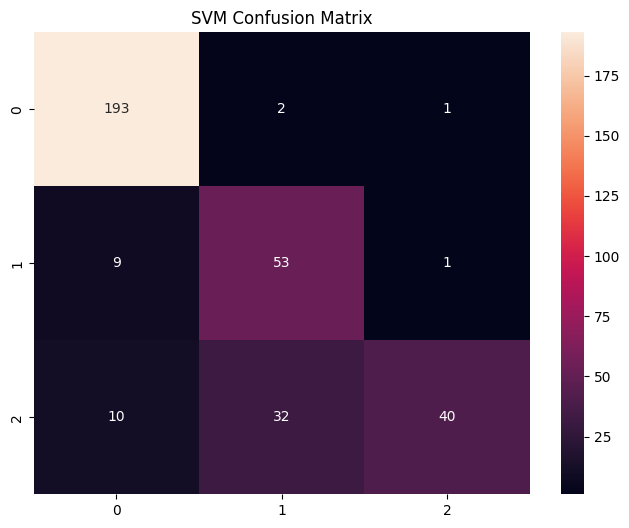

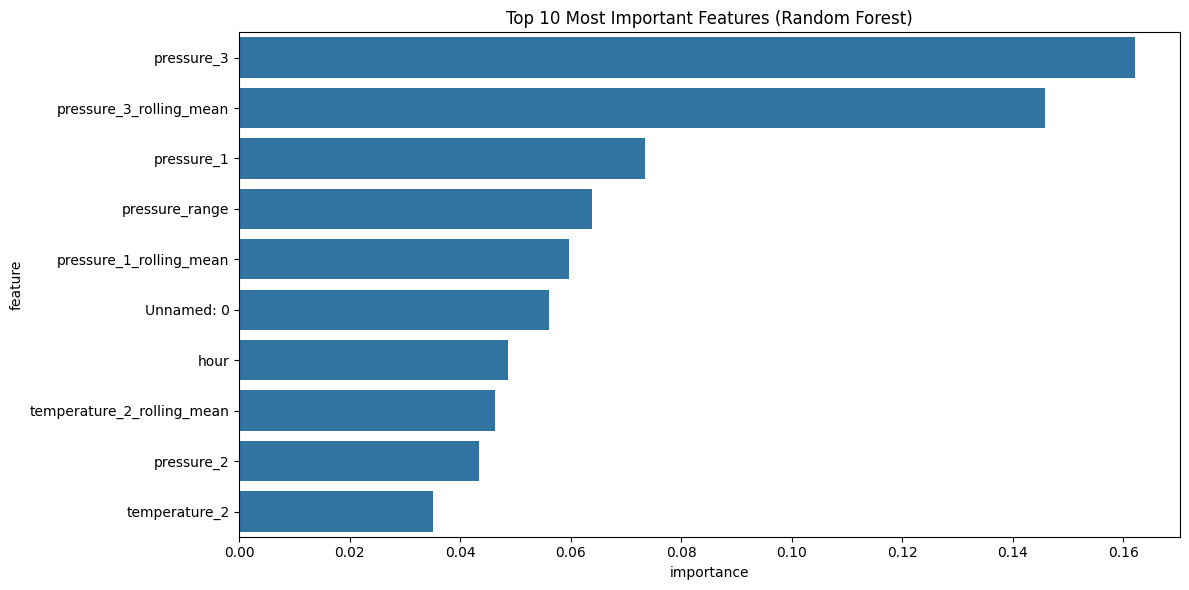


Processing test data...

Missing values before imputation:
Unnamed: 0                    0
pressure_1                    0
pressure_2                    0
pressure_3                    0
temperature_1                 0
temperature_2                 0
temperature_3                 0
temperature_4                 0
vibration                     0
hour                          0
day                           0
month                         0
pressure_range                0
temp_range                    0
pressure_1_rolling_mean       0
pressure_2_rolling_mean       0
pressure_3_rolling_mean       0
temperature_1_rolling_mean    0
temperature_2_rolling_mean    0
temperature_3_rolling_mean    0
temperature_4_rolling_mean    0
vibration_rolling_mean        0
dtype: int64

Missing values after imputation:
Unnamed: 0                    0
pressure_1                    0
pressure_2                    0
pressure_3                    0
temperature_1                 0
temperature_2                

,Model,Accuracy,F1 Score
0,Random Forest,0.988270,0.988238
1,Gradient Boosting,0.979472,0.979424
2,SVM,0.838710,0.829486


In [24]:
# Usage
predictor = PumpLeakagePredictor()

# Load and train on training data
train_df = pd.read_csv('trainingData.csv')
predictor.train(train_df)

# Make predictions on test data
test_df = pd.read_csv('testData.csv')
predictions_df = predictor.predict(test_df)

# Save predictions
predictions_df.to_csv('predictions.csv', index=False)

# Print model comparison
predictor.print_model_comparison()